In [1]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None

### TODO:
- Load sample data from json file
- Fill sample data to Dataframe
- Standardize data
- Bins data to buckets latency **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]***
- Simulator increase[$time_vector] = y - x [$time_vector] (y: last_increament, x: first_increament)
- Simulator rate[$time_vector] = increase()/$time_vector (seconds) -> incre per-second
- Simulator linear interpolation -> Calculate quantile

In [172]:
DATA = []
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
TIME_VECTOR = 5 # second

### Load sample data from json file
Sample format row data:
```python
{"timestamp": "23/01/2024, 10:44:34", "path": "/users", "method": "GET", "service_name": "process_log", "controller_pod": "pod-1", "duration_time": 0.176}
```

In [3]:
import json


def get_data_from_file(filename: str):
    f = open(filename, "r")
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        DATA.append(row)

In [4]:
get_data_from_file("../statics/request_data_with_duration_time.json")

### Fill sample data to Dataframe
Columns list: **[timestamp, path, method, service_name, controller_pod, duration_time]**

In [5]:
# Create dataframe
root_df = pd.DataFrame(DATA)

In [6]:
root_df

,timestamp,path,method,service_name,controller_pod,duration_time
0,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.176
1,"23/01/2024, 10:44:34",/home,GET,process_log,pod-2,0.654
2,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.562
3,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.690
4,"23/01/2024, 10:44:35",/users,GET,process_log,pod-1,0.333
...,...,...,...,...,...,...
14793,"23/01/2024, 11:34:26",/home,GET,process_log,pod-1,0.148
14794,"23/01/2024, 11:34:26",/users,GET,process_log,pod-1,0.145
14795,"23/01/2024, 11:34:26",/users,GET,process_log,pod-2,0.298
14796,"23/01/2024, 11:34:26",/users,GET,process_log,pod-1,0.243


### Standardlize data

In [7]:
# Re format timestamp to  "%d/%m/%Y, %H:%M:%S"
from datetime import datetime
root_df['timestamp'] = root_df['timestamp'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))

In [8]:
# Bins data to bucket latency
def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    res.append("+Inf")
    return res

root_df["le"] = root_df["duration_time"].apply(lambda x: bucketing(x))

In [9]:
root_df

,timestamp,path,method,service_name,controller_pod,duration_time,le
0,2024-01-23 10:44:34,/users,GET,process_log,pod-1,0.176,"[0.25, 0.5, +Inf]"
1,2024-01-23 10:44:34,/home,GET,process_log,pod-2,0.654,[+Inf]
2,2024-01-23 10:44:34,/users,GET,process_log,pod-1,0.562,[+Inf]
3,2024-01-23 10:44:34,/users,GET,process_log,pod-1,0.690,[+Inf]
4,2024-01-23 10:44:35,/users,GET,process_log,pod-1,0.333,"[0.5, +Inf]"
...,...,...,...,...,...,...,...
14793,2024-01-23 11:34:26,/home,GET,process_log,pod-1,0.148,"[0.25, 0.5, +Inf]"
14794,2024-01-23 11:34:26,/users,GET,process_log,pod-1,0.145,"[0.25, 0.5, +Inf]"
14795,2024-01-23 11:34:26,/users,GET,process_log,pod-2,0.298,"[0.5, +Inf]"
14796,2024-01-23 11:34:26,/users,GET,process_log,pod-1,0.243,"[0.25, 0.5, +Inf]"


In [10]:
# Get distinct group for bins value latency for each group
group_dataset = root_df.groupby(['path', 'method', 'service_name', 'controller_pod']).count().reset_index()[['path', 'method', 'service_name', 'controller_pod']]

In [11]:
group_dataset # <- Return all group existed in dataset, next step do bins value of each group into bucket list: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]** 

,path,method,service_name,controller_pod
0,/home,GET,process_log,pod-1
1,/home,GET,process_log,pod-2
2,/users,GET,process_log,pod-1
3,/users,GET,process_log,pod-2


In [12]:
from typing import Dict


def bins_value(row, bins_dict: Dict):
    # unwind data from list
    list_le = row['le']
    for le in list_le:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    return new_row

In [13]:
# Bins value to bucket latency
df_by_group = {}
for idx, dataset in group_dataset.iterrows():
    bins_dict = {k: 0 for k in BUCKETS}
    bins_dict['+Inf'] = 0  # type: ignore
    # Query for each group get dataframe and save it to datastructure
    df_by_group[idx] = root_df.query(
        "path == @dataset['path'] \
                and method == @dataset['method'] \
                and service_name == @dataset['service_name'] \
                and controller_pod == @dataset['controller_pod']")\
        .apply(lambda x: bins_value(x, bins_dict), axis=1)

# Join all group dataframe processed by one dataframe
raw_df = pd.concat(df_by_group.values()).reset_index(drop=True)

In [14]:
# Rename columns
columns_change = {
    0.005: "le_0.005",
    0.01: "le_0.01",
    0.025: "le_0.025",
    0.05: "le_0.05",
    0.1: "le_0.1",
    0.25: "le_0.25",
    0.5: "le_0.5",
    "+Inf": "+Inf"
}
raw_df = raw_df.rename(columns=columns_change)

In [15]:
# Select columns necessary for analysis
list_column_select = ["timestamp", "path", "method", "service_name",
                      "controller_pod"] + [bucket for bucket in columns_change.values()]
raw_df = raw_df[list_column_select]

<Axes: xlabel='timestamp'>

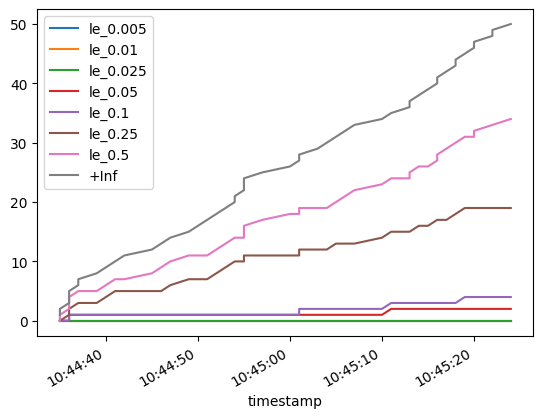

In [16]:
# Check and ensure value calculated is counter for calculate increment
raw_df[0:50][["timestamp"] + [bucket for bucket in columns_change.values()]
             ].plot(kind="line", x="timestamp")

In [17]:
# Group data interval 1 second
# Only consider about latency bucket -> Get newest value increament by second
raw_df = raw_df.groupby(["timestamp", "path", "controller_pod"]).nth(-1).reset_index(drop=True)

In [65]:
raw_df

,timestamp,path,method,service_name,controller_pod,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
0,2024-01-23 10:44:35,/home,GET,process_log,pod-1,0,0,0,0,0,0,1,2
1,2024-01-23 10:44:36,/home,GET,process_log,pod-1,0,0,0,1,1,2,4,5
2,2024-01-23 10:44:37,/home,GET,process_log,pod-1,0,0,0,1,1,3,5,7
3,2024-01-23 10:44:39,/home,GET,process_log,pod-1,0,0,0,1,1,3,5,8
4,2024-01-23 10:44:40,/home,GET,process_log,pod-1,0,0,0,1,1,4,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078,2024-01-23 11:34:21,/users,GET,process_log,pod-2,25,46,121,239,481,1142,2300,3708
9079,2024-01-23 11:34:22,/users,GET,process_log,pod-2,25,46,121,239,481,1142,2301,3710
9080,2024-01-23 11:34:23,/users,GET,process_log,pod-2,25,46,121,239,481,1142,2303,3712
9081,2024-01-23 11:34:24,/users,GET,process_log,pod-2,25,46,121,239,481,1142,2303,3714


In [138]:

def increase(row_data):
    for v in columns_change.values():
        v: str
        row_data[f"increase[5s]{v}"] = row_data[v]['last'] - row_data[v]['first']
        print(row_data[f"increase[5s]{v}"])
    return row_data

In [173]:
bucket_columns = {v: ["first", "last"] for v in columns_change.values()}

# Implement increase for each bucket
raw_df_resample = raw_df.groupby(["path", "method", "service_name", "controller_pod"]).resample(
    rule=f"{TIME_VECTOR}s", on="timestamp", label="right", closed="right").agg(bucket_columns).reset_index()  # type: ignore

In [174]:
raw_df_resample[0:10]

path method service_name controller_pod           timestamp le_0.005       \
                                                                   first last   
0  /home    GET  process_log          pod-1 2024-01-23 10:44:35      0.0  0.0   
1  /home    GET  process_log          pod-1 2024-01-23 10:44:40      0.0  0.0   
2  /home    GET  process_log          pod-1 2024-01-23 10:44:45      0.0  0.0   
3  /home    GET  process_log          pod-1 2024-01-23 10:44:50      0.0  0.0   
4  /home    GET  process_log          pod-1 2024-01-23 10:44:55      0.0  0.0   
5  /home    GET  process_log          pod-1 2024-01-23 10:45:00      0.0  0.0   
6  /home    GET  process_log          pod-1 2024-01-23 10:45:05      0.0  0.0   
7  /home    GET  process_log          pod-1 2024-01-23 10:45:10      0.0  0.0   
8  /home    GET  process_log          pod-1 2024-01-23 10:45:15      0.0  0.0   
9  /home    GET  process_log          pod-1 2024-01-23 10:45:20      0.0  0.0   

  le_0.01      le_0.025  ... le_0.05      le_0.1      le_0.25       le_0.5  \
    first last    first  ...   first last  first last   first  last  first   
0     0.0  0.0      0.0  ...     0.0  0.0    0.0  0.0     0.0   0.0    1.0   
1     0.0  0.0      0.0  ...     1.0  1.0    1.0  1.0     2.0   4.0    4.0   
2     0.0  0.0      0.0  ...     1.0  1.0    1.0  1.0     5.0   5.0    7.0   
3     0.0  0.0      0.0  ...     1.0  1.0    1.0  1.0     5.0   7.0    9.0   
4     0.0  0.0      0.0  ...     1.0  1.0    1.0  1.0     7.0  11.0   11.0   
5     0.0  0.0      0.0  ...     1.0  1.0    1.0  1.0    11.0  11.0   17.0   
6     0.0  0.0      0.0  ...     1.0  1.0    2.0  2.0    12.0  13.0   19.0   
7     0.0  0.0      0.0  ...     1.0  1.0    2.0  2.0    13.0  14.0   21.0   
8     0.0  0.0      0.0  ...     2.0  2.0    3.0  3.0    15.0  16.0   24.0   
9     0.0  0.0      0.0  ...     2.0  2.0    3.0  4.0    17.0  19.0   28.0   

         +Inf        
   last first  last  
0   1.0   2.0   2.0  
1   6.0   5.0   9.0  
2   8.0  10.0  12.0  
3  11.0  13.0  16.0  
4  16.0  17.0  24.0  
5  18.0  25.0  26.0  
6  20.0  28.0  31.0  
7  23.0  32.0  34.0  
8  26.0  35.0  39.0  
9  32.0  41.0  47.0  

[10 rows x 21 columns]

In [162]:
# Simulator increase()
def increase(x, y):
    return y - x

# Simulator rate()
def rate(x, y, time_vector: int):
    return increase(x, y) / time_vector

,timestamp,path,method,controller_pod,inc()_le_0.005,inc()_le_0.01,inc()_le_0.025,inc()_le_0.05,inc()_le_0.1,inc()_le_0.25,inc()_le_0.5,inc()_+Inf
0,2024-01-23 10:44:35,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-01-23 10:44:40,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0
2,2024-01-23 10:44:45,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,2024-01-23 10:44:50,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0
4,2024-01-23 10:44:55,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,4.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2024-01-23 11:34:10,/users,GET,pod-2,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
2394,2024-01-23 11:34:15,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0
2395,2024-01-23 11:34:20,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.0,1.0,2.0,6.0
2396,2024-01-23 11:34:25,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0


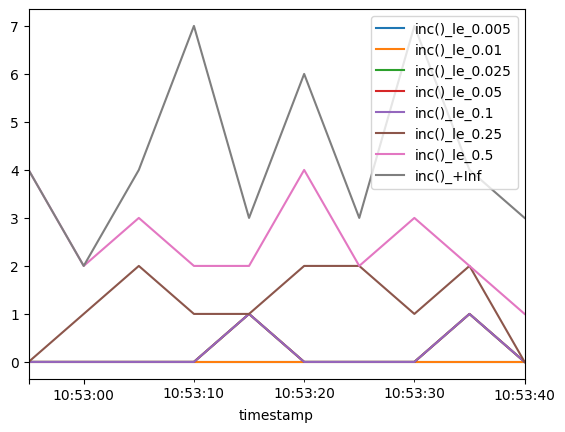

In [175]:
# Apply calculate increase()

df_value_incre = pd.DataFrame()
for bucket in columns_change.values():
    df_value_incre['timestamp'] = raw_df_resample['timestamp']
    df_value_incre['path'] = raw_df_resample['path']
    df_value_incre['method'] = raw_df_resample['method']
    df_value_incre['controller_pod'] = raw_df_resample['controller_pod']
    df_value_incre[f'inc()_{bucket}'] = increase(
        raw_df_resample[bucket]['first'], raw_df_resample[bucket]['last'])
df_value_incre[100:110].plot(x="timestamp")
df_value_incre

,timestamp,path,method,controller_pod,rat()_le_0.005,rat()_le_0.01,rat()_le_0.025,rat()_le_0.05,rat()_le_0.1,rat()_le_0.25,rat()_le_0.5,rat()_+Inf
0,2024-01-23 10:44:35,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-01-23 10:44:40,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.4,0.4,0.8
2,2024-01-23 10:44:45,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4
3,2024-01-23 10:44:50,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.4,0.4,0.6
4,2024-01-23 10:44:55,/home,GET,pod-1,0.0,0.0,0.0,0.0,0.0,0.8,1.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2024-01-23 11:34:10,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.2,0.2,0.4,0.4
2394,2024-01-23 11:34:15,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.0,0.4,0.6,0.8
2395,2024-01-23 11:34:20,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.0,0.2,0.4,1.2
2396,2024-01-23 11:34:25,/users,GET,pod-2,0.0,0.0,0.0,0.0,0.0,0.0,0.6,1.2


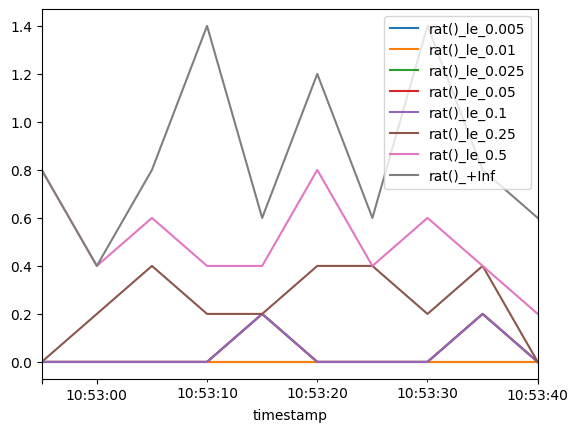

In [176]:
# Apply calculate rate()

df_value_rate = pd.DataFrame()
for bucket in columns_change.values():
    df_value_rate['timestamp'] = raw_df_resample['timestamp']
    df_value_rate['path'] = raw_df_resample['path']
    df_value_rate['method'] = raw_df_resample['method']
    df_value_rate['controller_pod'] = raw_df_resample['controller_pod']
    df_value_rate[f'rat()_{bucket}'] = rate(
        raw_df_resample[bucket]['first'],
        raw_df_resample[bucket]['last'],
        time_vector=TIME_VECTOR
    )
df_value_rate[100:110].plot(x="timestamp")
df_value_rate